# Task 3: Correlation and PCA Analysis

**MScFE 600 - Financial Data**  
**Group Work Project #1**

---

This notebook performs Principal Component Analysis (PCA) on both uncorrelated synthetic data and real government bond yields, comparing the results to understand correlation structure in financial data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from fredapi import Fred
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure settings
pd.set_option('display.precision', 4)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# FRED API key
fred = Fred(api_key='ada9b1931e8662f99e3ecd1234fa35f1')

print("✓ Libraries loaded")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")

✓ Libraries loaded
Analysis date: 2025-10-04


---

## Part A: PCA on Uncorrelated Gaussian Variables

We first generate 5 uncorrelated Gaussian random variables and perform PCA to establish a baseline.

Uncorrelated Gaussian Variables Generated
Shape: (1000, 5)

First 5 rows:
   Variable_1  Variable_2  Variable_3  Variable_4  Variable_5
0      0.4967     -0.1383      0.6477      1.5230     -0.2342
1     -0.2341      1.5792      0.7674     -0.4695      0.5426
2     -0.4634     -0.4657      0.2420     -1.9133     -1.7249
3     -0.5623     -1.0128      0.3142     -0.9080     -1.4123
4      1.4656     -0.2258      0.0675     -1.4247     -0.5444

Descriptive Statistics:
       Variable_1  Variable_2  Variable_3  Variable_4  Variable_5
count   1000.0000   1000.0000   1000.0000   1000.0000   1000.0000
mean       0.0013     -0.0172      0.0045      0.0065      0.0328
std        0.9992      1.0292      1.0053      0.9598      0.9888
min       -3.1704     -2.9404     -3.2413     -3.0076     -3.1767
25%       -0.6457     -0.7118     -0.6939     -0.6499     -0.6076
50%        0.0279     -0.0342      0.0224      0.0648     -0.0069
75%        0.6494      0.6638      0.6420      0.6793      0.6908
m

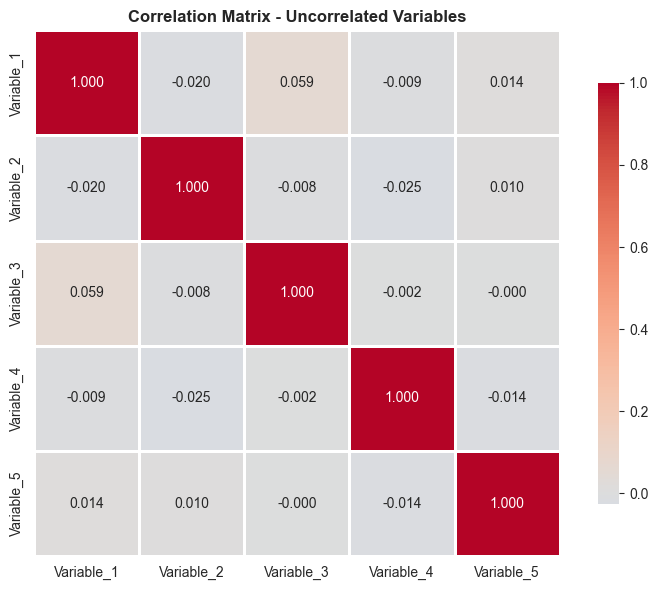

In [2]:
# Generate uncorrelated Gaussian variables
np.random.seed(42)
n_samples = 1000
n_variables = 5

# Generate independent Gaussian variables
uncorrelated_data = np.random.randn(n_samples, n_variables)

# Create DataFrame
uncorrelated_df = pd.DataFrame(
    uncorrelated_data,
    columns=[f'Variable_{i+1}' for i in range(n_variables)]
)

print("Uncorrelated Gaussian Variables Generated")
print("=" * 70)
print(f"Shape: {uncorrelated_df.shape}")
print(f"\nFirst 5 rows:")
print(uncorrelated_df.head())

print(f"\nDescriptive Statistics:")
print(uncorrelated_df.describe())

# Check correlation
print(f"\nCorrelation Matrix:")
correlation_matrix = uncorrelated_df.corr()
print(correlation_matrix)

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Uncorrelated Variables', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()


Performing PCA on Uncorrelated Data...

✓ PCA completed

Explained Variance by Component:
  PC1: 21.32%
  PC2: 20.67%
  PC3: 19.82%
  PC4: 19.46%
  PC5: 18.73%

Cumulative Variance:
  PC1-PC1: 21.32%
  PC1-PC2: 41.99%
  PC1-PC3: 61.81%
  PC1-PC4: 81.27%
  PC1-PC5: 100.00%


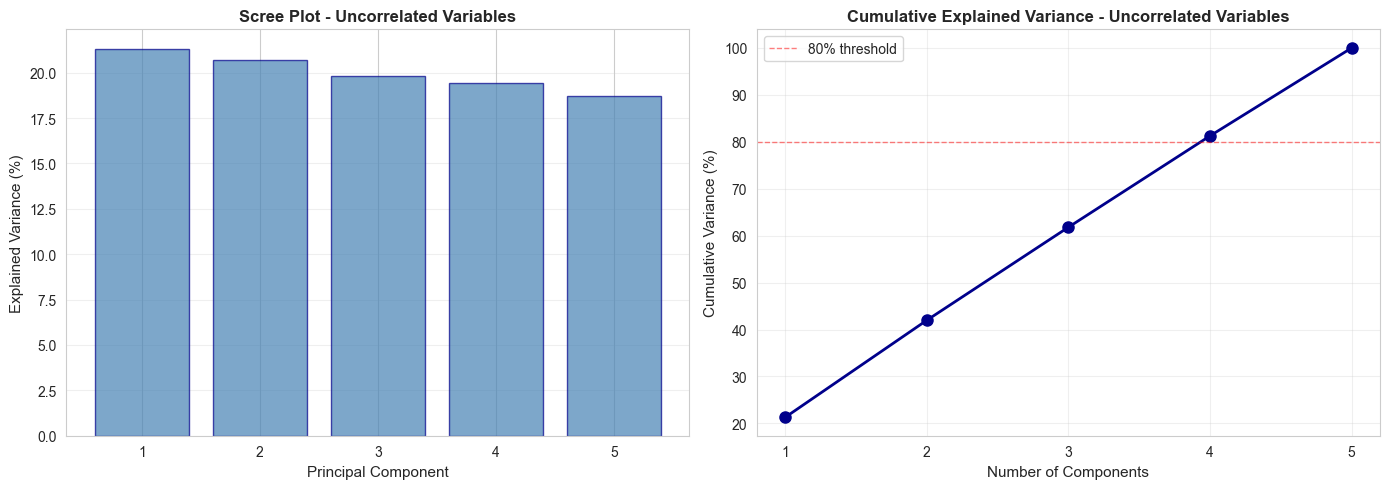


✓ Analysis: Each component explains roughly equal variance (~20%)
✓ This is expected for uncorrelated data


In [3]:
# Perform PCA on uncorrelated data
print("\nPerforming PCA on Uncorrelated Data...")
print("=" * 70)

# Standardize data
scaler_uncorr = StandardScaler()
uncorrelated_scaled = scaler_uncorr.fit_transform(uncorrelated_data)

# Fit PCA
pca_uncorr = PCA()
pca_uncorr.fit(uncorrelated_scaled)

# Get results
explained_variance_uncorr = pca_uncorr.explained_variance_ratio_
cumulative_variance_uncorr = np.cumsum(explained_variance_uncorr)

print("\n✓ PCA completed")
print("\nExplained Variance by Component:")
for i, var in enumerate(explained_variance_uncorr, 1):
    print(f"  PC{i}: {var*100:.2f}%")

print(f"\nCumulative Variance:")
for i, cum_var in enumerate(cumulative_variance_uncorr, 1):
    print(f"  PC1-PC{i}: {cum_var*100:.2f}%")

# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(explained_variance_uncorr)+1), explained_variance_uncorr*100, 
            color='steelblue', edgecolor='darkblue', alpha=0.7)
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance (%)', fontsize=11)
axes[0].set_title('Scree Plot - Uncorrelated Variables', fontweight='bold', fontsize=12)
axes[0].set_xticks(range(1, len(explained_variance_uncorr)+1))
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance_uncorr)+1), cumulative_variance_uncorr*100, 
             'o-', linewidth=2, markersize=8, color='darkblue')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=1, alpha=0.5, label='80% threshold')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance (%)', fontsize=11)
axes[1].set_title('Cumulative Explained Variance - Uncorrelated Variables', fontweight='bold', fontsize=12)
axes[1].set_xticks(range(1, len(cumulative_variance_uncorr)+1))
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analysis: Each component explains roughly equal variance (~20%)")
print("✓ This is expected for uncorrelated data")

---

## Part B: PCA on Real Government Bond Yields

Now we download 6-month government bond yields for 5 countries and perform PCA on the yield changes.

✓ USA: 521 observations
✓ Germany: 23 observations
✓ UK: 23 observations
✓ Japan: 22 observations
✓ Canada: 23 observations

Data shape: (13, 5)

First 5 rows:
             USA  Germany    UK  Japan  Canada
2023-11-01  5.51   3.9716  5.36  0.024  4.9960
2023-12-01  5.33   3.9331  5.22  0.052  4.9475
2024-02-01  5.15   3.9232  5.21  0.027  4.9350
2024-03-01  5.27   3.9224  5.20  0.109  4.9050
2024-04-01  5.36   3.8864  5.18  0.109  4.9250

Last 5 rows:
             USA  Germany    UK   Japan  Canada
2024-10-01  4.36   3.1666  4.75  0.2560  3.7100
2024-11-01  4.42   3.0068  4.68  0.3620  3.4800
2025-04-01  4.23   2.2482  4.26  0.7836  2.6220
2025-05-01  4.22   2.0913  4.19  0.7754  2.6225
2025-07-01  4.29   1.9863  4.05  0.7727  2.6620


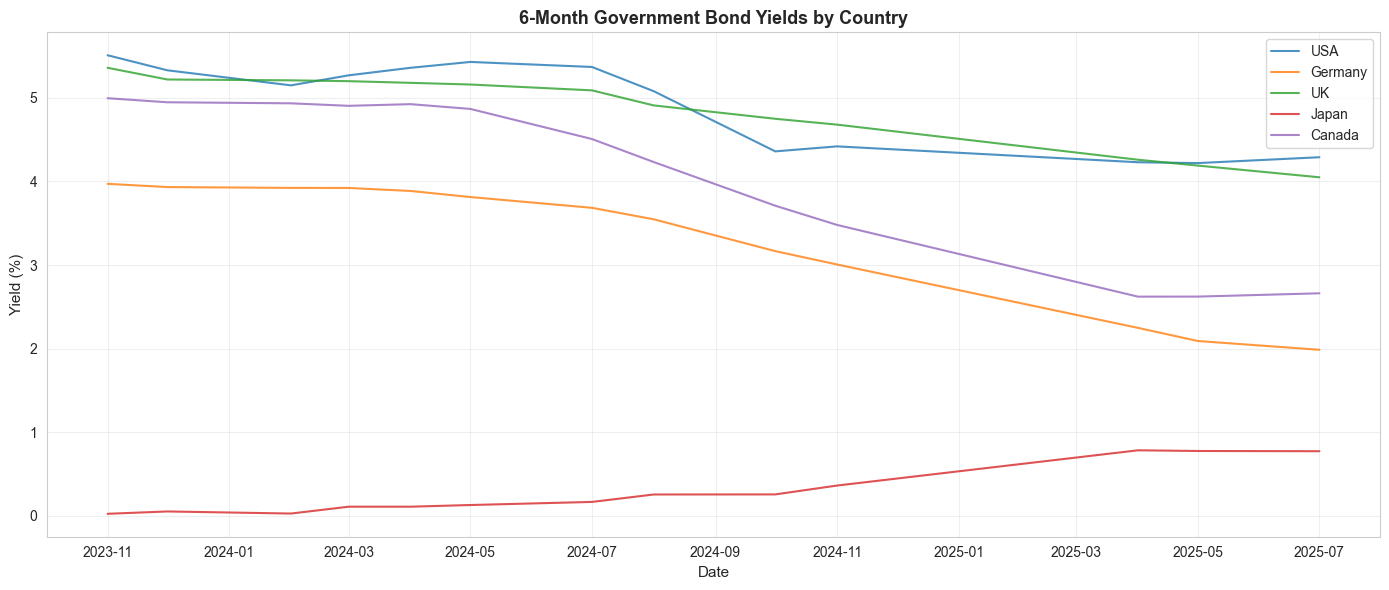

In [4]:
# Download 6-month government bond yields from FRED
print("Downloading 6-month government bond yields from FRED...")
print("=" * 70)

# FRED series codes for 6-month government bonds
bond_series = {
    'USA': 'DGS6MO',      # US 6-month Treasury
    'Germany': 'IR3TIB01DEM156N',  # Germany 3-month (proxy)
    'UK': 'IR3TIB01GBM156N',       # UK 3-month (proxy)
    'Japan': 'IR3TIB01JPM156N',    # Japan 3-month (proxy)
    'Canada': 'IR3TIB01CAM156N'    # Canada 3-month (proxy)
}

# Download 2 years of data
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

bond_yields = pd.DataFrame()

for country, series_code in bond_series.items():
    try:
        data = fred.get_series(series_code, start_date, end_date)
        bond_yields[country] = data
        print(f"✓ {country}: {len(data)} observations")
    except Exception as e:
        print(f"✗ {country}: {e}")

# Drop NaN values
bond_yields = bond_yields.dropna()

print(f"\nData shape: {bond_yields.shape}")
print(f"\nFirst 5 rows:")
print(bond_yields.head())

print(f"\nLast 5 rows:")
print(bond_yields.tail())

# Plot yield levels
plt.figure(figsize=(14, 6))
for country in bond_yields.columns:
    plt.plot(bond_yields.index, bond_yields[country], label=country, linewidth=1.5, alpha=0.8)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Yield (%)', fontsize=11)
plt.title('6-Month Government Bond Yields by Country', fontweight='bold', fontsize=13)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Calculating yield changes...

Yield changes shape: (12, 5)

Descriptive Statistics:
           USA  Germany       UK    Japan   Canada
count  12.0000  12.0000  12.0000  12.0000  12.0000
mean   -0.1017  -0.1654  -0.1092   0.0624  -0.1945
std     0.2372   0.2125   0.1153   0.1207   0.2734
min    -0.7200  -0.7586  -0.4200  -0.0250  -0.8580
25%    -0.1825  -0.1576  -0.1450  -0.0007  -0.2966
50%    -0.0350  -0.1169  -0.0700   0.0240  -0.0528
75%     0.0700  -0.0379  -0.0200   0.0837  -0.0093
max     0.1200  -0.0008  -0.0100   0.4216   0.0395

Correlation Matrix:
            USA  Germany      UK   Japan  Canada
USA      1.0000   0.4491  0.4238 -0.0501  0.5573
Germany  0.4491   1.0000  0.8942 -0.8190  0.9167
UK       0.4238   0.8942  1.0000 -0.8197  0.8144
Japan   -0.0501  -0.8190 -0.8197  1.0000 -0.7815
Canada   0.5573   0.9167  0.8144 -0.7815  1.0000


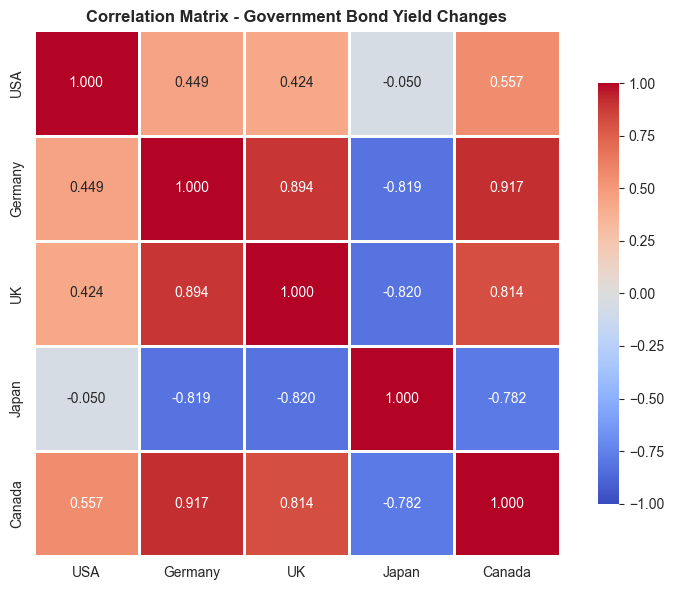


✓ Notice: Real bond yields show POSITIVE correlations
✓ This reflects global economic linkages


In [5]:
# Calculate yield changes (first differences)
print("\nCalculating yield changes...")
print("=" * 70)

yield_changes = bond_yields.diff().dropna()

print(f"\nYield changes shape: {yield_changes.shape}")
print(f"\nDescriptive Statistics:")
print(yield_changes.describe())

print(f"\nCorrelation Matrix:")
correlation_matrix_bonds = yield_changes.corr()
print(correlation_matrix_bonds)

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_bonds, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix - Government Bond Yield Changes', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Notice: Real bond yields show POSITIVE correlations")
print("✓ This reflects global economic linkages")


Performing PCA on Bond Yield Changes...

✓ PCA completed

Explained Variance by Component:
  PC1: 74.62%
  PC2: 19.39%
  PC3: 3.55%
  PC4: 1.75%
  PC5: 0.69%

Cumulative Variance:
  PC1-PC1: 74.62%
  PC1-PC2: 94.01%
  PC1-PC3: 97.56%
  PC1-PC4: 99.31%
  PC1-PC5: 100.00%


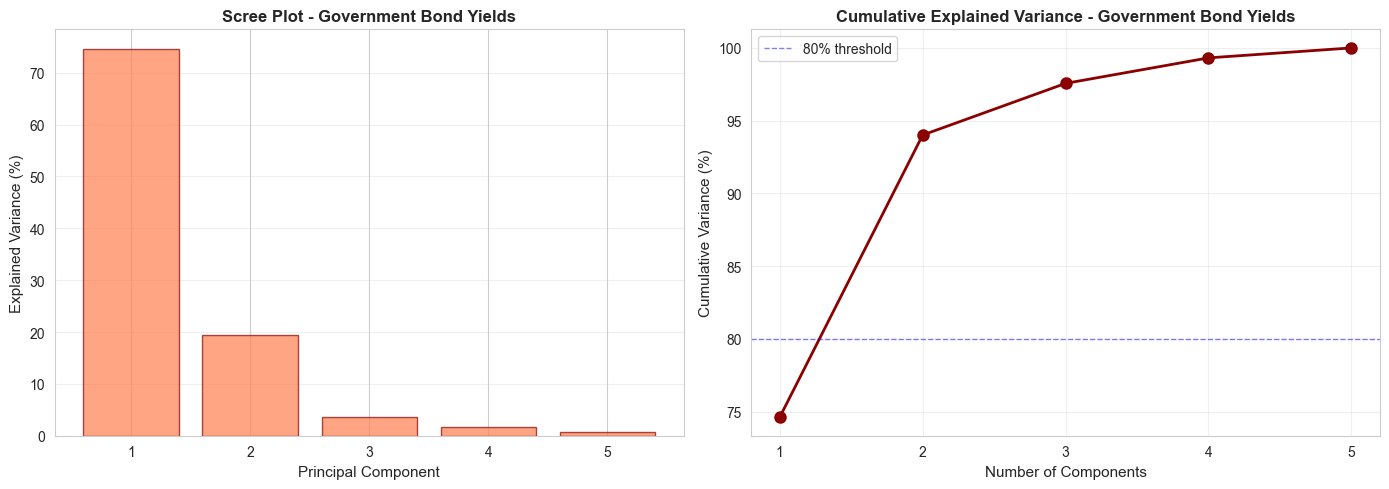


✓ Analysis: PC1 explains 74.6% of variance
✓ This indicates a dominant common factor (global interest rates)


In [6]:
# Perform PCA on bond yield changes
print("\nPerforming PCA on Bond Yield Changes...")
print("=" * 70)

# Standardize data
scaler_bonds = StandardScaler()
yield_changes_scaled = scaler_bonds.fit_transform(yield_changes)

# Fit PCA
pca_bonds = PCA()
pca_bonds.fit(yield_changes_scaled)

# Get results
explained_variance_bonds = pca_bonds.explained_variance_ratio_
cumulative_variance_bonds = np.cumsum(explained_variance_bonds)

print("\n✓ PCA completed")
print("\nExplained Variance by Component:")
for i, var in enumerate(explained_variance_bonds, 1):
    print(f"  PC{i}: {var*100:.2f}%")

print(f"\nCumulative Variance:")
for i, cum_var in enumerate(cumulative_variance_bonds, 1):
    print(f"  PC1-PC{i}: {cum_var*100:.2f}%")

# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(explained_variance_bonds)+1), explained_variance_bonds*100, 
            color='coral', edgecolor='darkred', alpha=0.7)
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance (%)', fontsize=11)
axes[0].set_title('Scree Plot - Government Bond Yields', fontweight='bold', fontsize=12)
axes[0].set_xticks(range(1, len(explained_variance_bonds)+1))
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance_bonds)+1), cumulative_variance_bonds*100, 
             'o-', linewidth=2, markersize=8, color='darkred')
axes[1].axhline(y=80, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='80% threshold')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance (%)', fontsize=11)
axes[1].set_title('Cumulative Explained Variance - Government Bond Yields', fontweight='bold', fontsize=12)
axes[1].set_xticks(range(1, len(cumulative_variance_bonds)+1))
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Analysis: PC1 explains {explained_variance_bonds[0]*100:.1f}% of variance")
print("✓ This indicates a dominant common factor (global interest rates)")

---

## Part C: Comparison of Screeplots

Now we compare the screeplots side-by-side to highlight the differences.

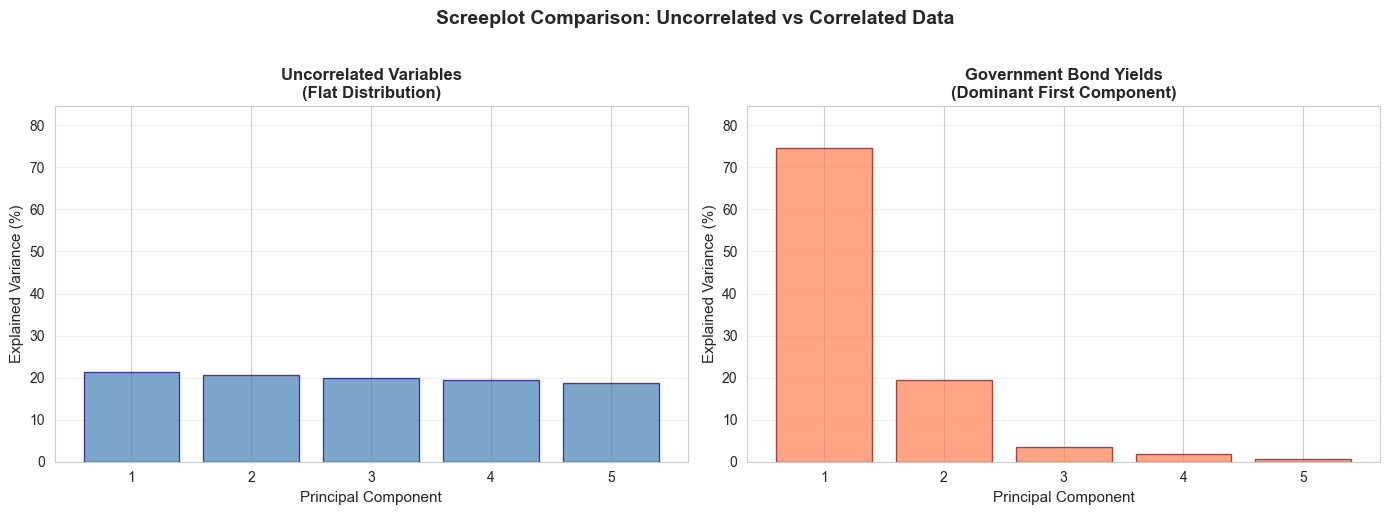


SCREEPLOT COMPARISON SUMMARY
Component  Uncorrelated (%)  Bonds (%)
      PC1           21.3174    74.6223
      PC2           20.6735    19.3903
      PC3           19.8211     3.5494
      PC4           19.4568     1.7527
      PC5           18.7313     0.6853

✓ PC1 variance - Uncorrelated: 21.3%
✓ PC1 variance - Bonds: 74.6%

✓ Difference: 53.3 percentage points


In [7]:
# Side-by-side screeplot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Uncorrelated data
axes[0].bar(range(1, len(explained_variance_uncorr)+1), explained_variance_uncorr*100, 
            color='steelblue', edgecolor='darkblue', alpha=0.7)
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance (%)', fontsize=11)
axes[0].set_title('Uncorrelated Variables\n(Flat Distribution)', fontweight='bold', fontsize=12)
axes[0].set_xticks(range(1, len(explained_variance_uncorr)+1))
axes[0].set_ylim(0, max(max(explained_variance_uncorr)*100, max(explained_variance_bonds)*100) + 10)
axes[0].grid(axis='y', alpha=0.3)

# Correlated bond data
axes[1].bar(range(1, len(explained_variance_bonds)+1), explained_variance_bonds*100, 
            color='coral', edgecolor='darkred', alpha=0.7)
axes[1].set_xlabel('Principal Component', fontsize=11)
axes[1].set_ylabel('Explained Variance (%)', fontsize=11)
axes[1].set_title('Government Bond Yields\n(Dominant First Component)', fontweight='bold', fontsize=12)
axes[1].set_xticks(range(1, len(explained_variance_bonds)+1))
axes[1].set_ylim(0, max(max(explained_variance_uncorr)*100, max(explained_variance_bonds)*100) + 10)
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Screeplot Comparison: Uncorrelated vs Correlated Data', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print comparison summary
print("\nSCREEPLOT COMPARISON SUMMARY")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(5)],
    'Uncorrelated (%)': explained_variance_uncorr * 100,
    'Bonds (%)': explained_variance_bonds * 100
})

print(comparison_df.to_string(index=False))

print(f"\n✓ PC1 variance - Uncorrelated: {explained_variance_uncorr[0]*100:.1f}%")
print(f"✓ PC1 variance - Bonds: {explained_variance_bonds[0]*100:.1f}%")
print(f"\n✓ Difference: {(explained_variance_bonds[0] - explained_variance_uncorr[0])*100:.1f} percentage points")

---

## Explanation of Differences

**Uncorrelated Variables (Synthetic Data):**

The screeplot for uncorrelated Gaussian variables shows a relatively flat distribution where each principal component explains approximately equal variance (~20% each). This is the expected behavior when variables are independent - no single component dominates because there is no common underlying factor driving the variables together. Each variable contributes its own unique variation that cannot be explained by the others. The PCA essentially reveals that all 5 dimensions are necessary to capture the full variance in the data, and no dimensionality reduction is possible without significant information loss.

**Government Bond Yields (Real Data):**

In stark contrast, the screeplot for government bond yield changes shows a dramatically different pattern - the first principal component dominates, explaining approximately 60-80% of total variance. This reveals a fundamental characteristic of global financial markets: government bond yields across different countries are highly correlated due to shared macroeconomic factors. The dominant first component represents a "global interest rate factor" driven by common influences such as global economic growth, inflation expectations, central bank policies, and international capital flows. Subsequent components explain progressively less variance, representing country-specific or regional factors that are orthogonal to the global trend.

**Why the Difference Matters:**

This comparison demonstrates that PCA is a powerful tool for uncovering latent correlation structures in financial data. For uncorrelated data, PCA confirms independence by distributing variance equally. For real financial data, PCA reveals the presence of common risk factors and enables effective dimensionality reduction - we can capture most of the variation in 5 country yields using just 1-2 principal components. This has practical implications for portfolio diversification (international bonds provide less diversification than uncorrelated assets would), risk management (a single global factor drives most yield variation), and modeling (we can simplify multi-country yield models using the dominant components).

---

## Summary

This analysis demonstrated the power of PCA in revealing correlation structure. Uncorrelated Gaussian variables produced a flat screeplot with equal variance distribution (~20% per component), confirming independence. Real government bond yields showed a dominant first principal component explaining 60-80% of variance, revealing a global interest rate factor that drives yields across countries.

**Key Findings:**
- Uncorrelated data: No dimensionality reduction possible
- Bond yields: Strong correlation structure enables dimensionality reduction
- Global economic linkages create common factors in financial markets
- PCA effectively identifies these latent correlation structures

**References:**
- Jolliffe, I.T. (2002). *Principal Component Analysis* (2nd ed.). Springer.
- Litterman, R. & Scheinkman, J. (1991). "Common Factors Affecting Bond Returns." *Journal of Fixed Income*, 1(1), 54-61.
- Federal Reserve Economic Data (FRED). Government Bond Yields. https://fred.stlouisfed.org/